To be completed by 17 jan  
oof

In [0]:
%%capture
#Installs
!pip install -U transformers
!pip install -U fast-bert
!pip install -U fastai
!pip install -U scikit-learn
!pip install -U liwc-text-analysis --no-deps
!pip install -U spacy
!pip install -U spacy-lookups-data
!pip install -U scikit-multilearn
!pip install -U ninja
!python -m spacy download en_core_web_sm

In [3]:
from google.colab import drive
import pandas as pd
import numpy as np
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import fastai
from fastai.text import * 
from fastai.basics import *
from fastai.callbacks import * 
from fastai.callbacks.mem import PeakMemMetric
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from liwc import Liwc
from sklearn.metrics import accuracy_score,precision_recall_fscore_support, f1_score, classification_report
from collections import defaultdict
from plotly.offline import iplot
import cufflinks as cf

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

nlp = spacy.load('en_core_web_sm')
drive.mount('/content/drive')
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
cf.go_offline()

KeyError: ignored

In [0]:
labeled_comments = pd.read_csv("/content/drive/My Drive/affconsharedtask/labeled_cleaned.csv")
unlabeled_comments = pd.read_csv("/content/drive/My Drive/affconsharedtask/unlabeled_cleaned.csv")

categories = ['emotional_disclosure','information_disclosure','general_support','info_support','emo_support']
overall_categories = ['support','disclosive']
path = Path("/content/drive/My Drive/affconsharedtask/")

In [0]:
#@title Magic panel
lim = 5000 #@param {type:"slider", min:0, max:400000, step:1}
feature_type = 1 #@param {type:"slider", min:0, max:1, step:1}
#0,1: lsa,liwc
ff_bs = 256 #@param {type:"slider", min:0, max:1000, step:1}
seed = 1 #@param {type:"slider", min:0, max:500000, step:1}
lsa_comp = 500 #@param {type:"integer"}
N_h = 200 #@param {type:"slider", min:0, max:1000, step:1}
wd = 0.001 #@param {type:"slider", min:0, max:1, step:0.0001}





kf = KFold(n_splits=10,shuffle=True)


NameError: ignored

### Set up tfidf vectors for every sentence

(will not use this for input as dimensions too large)

In [6]:

punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    return mytokens


tfidf_vectorizer=TfidfVectorizer(tokenizer=spacy_tokenizer,ngram_range=(1,2),sublinear_tf=True)
comment_text = labeled_comments["full_text"]
comment_text = comment_text.append(unlabeled_comments["full_text"])

tfidf_vectorizer.fit(comment_text)

ul_tfidf = tfidf_vectorizer.transform(unlabeled_comments["full_text"][:lim])

l_tfidf = tfidf_vectorizer.transform(labeled_comments["full_text"])



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


### Latent Semantic Analysis

In [0]:
#Latent Semantic Analysis
svd = TruncatedSVD(n_components=lsa_comp, n_iter=7)
tfidf_vecs = l_tfidf
tfidf_vecs = scipy.sparse.vstack([tfidf_vecs,ul_tfidf])
svd.fit(tfidf_vecs)
l_lsa = svd.transform(l_tfidf)
ul_lsa = svd.transform(ul_tfidf)

### LIWC

In [8]:
#Load LIWC
LIWCLocation = path/'LIWC2015_English_Flat.dic'
lewk = Liwc(LIWCLocation)
liwc_cat_list =  lewk.categories
print(liwc_cat_list)




def conv_liwc(s):
    tokens = parser(s)
    cnt = lewk.parse([tok.text for tok in tokens])
    temp = [cnt[liwc_cat_list[k]] for k in liwc_cat_list]
    vec = np.array(temp,dtype=np.float64)
    l2_norm = np.linalg.norm(vec)
    if(l2_norm!=0.0):
        vec = vec/l2_norm
    return vec

l_liwc = labeled_comments["full_text"].apply(conv_liwc)
l_liwc = np.stack(l_liwc.values)
print(l_liwc)
ul_liwc = unlabeled_comments["full_text"][:lim].apply(conv_liwc)
ul_liwc = np.stack(ul_liwc.values)
l_liwc

{'1': 'function', '2': 'pronoun', '3': 'ppron', '4': 'i', '5': 'we', '6': 'you', '7': 'shehe', '8': 'they', '9': 'ipron', '10': 'article', '11': 'prep', '12': 'auxverb', '13': 'adverb', '14': 'conj', '15': 'negate', '20': 'verb', '21': 'adj', '22': 'compare', '23': 'interrog', '24': 'number', '25': 'quant', '30': 'affect', '31': 'posemo', '32': 'negemo', '33': 'anx', '34': 'anger', '35': 'sad', '40': 'social', '41': 'family', '42': 'friend', '43': 'female', '44': 'male', '50': 'cogproc', '51': 'insight', '52': 'cause', '53': 'discrep', '54': 'tentat', '55': 'certain', '56': 'differ', '60': 'percept', '61': 'see', '62': 'hear', '63': 'feel', '70': 'bio', '71': 'body', '72': 'health', '73': 'sexual', '74': 'ingest', '80': 'drives', '81': 'affiliation', '82': 'achiev', '83': 'power', '84': 'reward', '85': 'risk', '90': 'focuspast', '91': 'focuspresent', '92': 'focusfuture', '100': 'relativ', '101': 'motion', '102': 'space', '103': 'time', '110': 'work', '111': 'leisure', '112': 'home', '1

array([[0.738549, 0.246183, 0.123091, 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.316228, 0.316228, 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.639602, 0.213201, 0.213201, 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.656278, 0.154418, 0.077209, 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       ...,
       [0.371391, 0.371391, 0.185695, 0.185695, ..., 0.      , 0.      , 0.      , 0.      ],
       [0.540062, 0.231455, 0.231455, 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.768221, 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.693334, 0.154074, 0.154074, 0.      , ..., 0.      , 0.      , 0.      , 0.      ]])

In [35]:
l_liwc.shape


(12860, 73)

In [9]:
l_list = [l_lsa,l_liwc]
ul_list = [ul_lsa,ul_liwc]

l_vecs = l_list[feature_type]
lbls = labeled_comments[overall_categories]
ul_vecs = ul_list[feature_type]

l_df = pd.DataFrame()
l_df['vecs'] = list(l_vecs)
l_df = pd.concat([l_df,lbls],axis=1)

feat_len = l_vecs.shape[1]
l_df.head()

,vecs,support,disclosive
0,"[0.7385489458759964, 0.24618298195866545, 0.12...",0,0
1,"[0.31622776601683794, 0.31622776601683794, 0.0...",0,1
2,"[0.6396021490668313, 0.21320071635561041, 0.21...",1,0
3,"[0.6562777210098555, 0.15441828729643658, 0.07...",0,1
4,"[0.5345224838248488, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1


Create databunches

In [0]:
db = (ItemList.from_df(l_df,path,cols=['vecs'])
                      .split_by_rand_pct(0.1,seed=seed)
                      .label_from_df(cols=overall_categories)
                      .databunch(bs=ff_bs))

In [0]:
db.batch_size = ff_bs

### Features into a simple feedforward network

Not sure how to decide number of hidden layers, so will choose arbitrarily
3 hidden layers.

In [14]:
del simple_nn

gc.collect()
learn.destroy()
torch.cuda.empty_cache()


NameError: ignored

In [0]:
simple_nn = nn.Sequential(
    nn.Linear(feat_len,N_h),
    nn.BatchNorm1d(N_h),
    nn.ReLU(),
    nn.Dropout(0.2),
    torch.nn.Linear(N_h, N_h),
    nn.BatchNorm1d(N_h),
    nn.ReLU(),
    nn.Dropout(0.5),
    torch.nn.Linear(N_h, N_h),
    nn.BatchNorm1d(N_h),
    nn.ReLU(),
    nn.Dropout(0.5),
    torch.nn.Linear(N_h, N_h),
    nn.BatchNorm1d(N_h),
    nn.ReLU(),
    nn.Dropout(0.5),
    torch.nn.Linear(N_h, 2),    
)


In [0]:
f_beta = MultiLabelFbeta(beta=1,thresh=0.5)

learn =  Learner(db, 
                 simple_nn,
                 wd=wd,
                 metrics=[accuracy_thresh],
                 callback_fns=[PeakMemMetric]).to_fp16()

del f_beta

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 1.10E-01


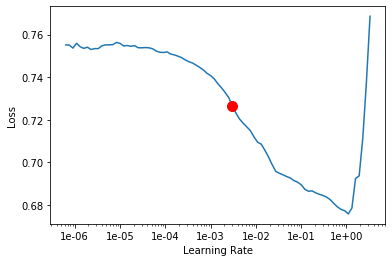

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

LSA:  
```
epoch	train_loss	valid_loss	accuracy_thresh	cpu used	peak	gpu used	peak	time
0	0.636183	0.626052	0.636858	0	0	2	0	00:13
1	0.624148	0.619928	0.650855	0	0	0	0	00:13
2	0.613007	0.614800	0.645412	0	0	0	0	00:13
3	0.614958	0.604974	0.667185	0	0	0	0	00:13
4	0.599618	0.604387	0.662908	0	0	0	0	00:13
5	0.584701	0.603347	0.668351	0	0	0	0	00:13
6	0.565517	0.616976	0.659798	0	0	0	0	00:13
7	0.549148	0.616111	0.662131	0	0	0	0	00:13
8	0.536717	0.626453	0.667574	0	0	0	0	00:14
9	0.522401	0.621340	0.666407	0	0	0	0	00:13
```

LIWC:  
```
epoch	train_loss	valid_loss	accuracy_thresh	cpu used	peak	gpu used	peak	time
0	0.686480	0.659365	0.636470	0	0	0	2	00:02
1	0.627514	0.583118	0.676905	0	0	0	2	00:02
2	0.596558	0.578568	0.687792	0	0	0	2	00:02
3	0.576689	0.575517	0.689347	0	0	0	2	00:02
4	0.566410	0.571390	0.694790	0	0	0	2	00:02
5	0.556981	0.569140	0.700233	0	0	0	2	00:02
6	0.550828	0.567683	0.693624	0	0	0	2	00:02
7	0.545803	0.566346	0.693235	0	0	0	2	00:02
8	0.541043	0.567009	0.695956	0	0	0	2	00:02
9	0.536557	0.567588	0.694401	0	0	0	2	00:02
```



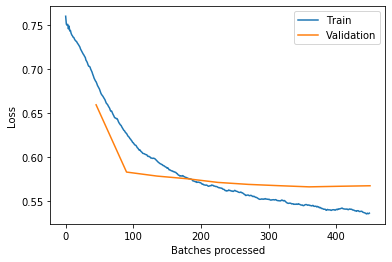

In [0]:
learn.fit_one_cycle(10,max_lr=min_grad_lr,moms=(0.8,0.9),callbacks=[SaveModelCallback(learn, every="improvement",monitor="valid_loss",name="simple_nn_liwc")])

epoch,train_loss,valid_loss,accuracy_thresh,cpu used,peak,gpu used,peak,time
0,0.686480,0.659365,0.636470,0,0,0,2,00:02
1,0.627514,0.583118,0.676905,0,0,0,2,00:02
2,0.596558,0.578568,0.687792,0,0,0,2,00:02
3,0.576689,0.575517,0.689347,0,0,0,2,00:02
4,0.566410,0.571390,0.694790,0,0,0,2,00:02
5,0.556981,0.569140,0.700233,0,0,0,2,00:02
6,0.550828,0.567683,0.693624,0,0,0,2,00:02
7,0.545803,0.566346,0.693235,0,0,0,2,00:02
8,0.541043,0.567009,0.695956,0,0,0,2,00:02
9,0.536557,0.567588,0.694401,0,0,0,2,00:02


Better model found at epoch 0 with valid_loss value: 0.6593654751777649.
Better model found at epoch 1 with valid_loss value: 0.5831180214881897.
Better model found at epoch 2 with valid_loss value: 0.5785678029060364.
Better model found at epoch 3 with valid_loss value: 0.5755171179771423.
Better model found at epoch 4 with valid_loss value: 0.5713900327682495.
Better model found at epoch 5 with valid_loss value: 0.5691401362419128.
Better model found at epoch 6 with valid_loss value: 0.5676830410957336.
Better model found at epoch 7 with valid_loss value: 0.5663461089134216.


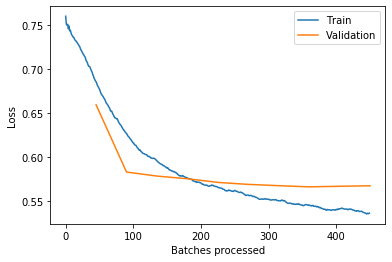

In [0]:
learn.recorder.plot_losses()

In [13]:
learn.load("simple_nn_liwc")

Learner(data=DataBunch;

Train: LabelList (11574 items)
x: ItemList
[0.738549 0.246183 0.123091 0.       ... 0.       0.       0.       0.      ],[0.316228 0.316228 0.       0.       ... 0.       0.       0.       0.      ],[0.639602 0.213201 0.213201 0.       ... 0.       0.       0.       0.      ],[0.656278 0.154418 0.077209 0.       ... 0.       0.       0.       0.      ],[0.560112 0.140028 0.140028 0.140028 ... 0.       0.       0.       0.      ]
y: MultiCategoryList
,disclosive,support,disclosive,disclosive
Path: /content/drive/My Drive/affconsharedtask;

Valid: LabelList (1286 items)
x: ItemList
[0.593732 0.084819 0.084819 0.       ... 0.       0.       0.       0.      ],[0.637993 0.141776 0.141776 0.070888 ... 0.       0.       0.       0.      ],[0.452267 0.150756 0.       0.       ... 0.       0.       0.       0.      ],[0.669534 0.257513 0.20601  0.       ... 0.       0.       0.       0.      ],[0.725589 0.167444 0.111629 0.       ... 0.       0.       0.       0.      

####Get results

In [19]:
#@title panel
#default activation function is derived from the loss when getting preds
preds,t_labels = learn.get_preds()
preds,t_labels = preds.numpy(),t_labels.numpy()
thresh = 0.5 #@param
preds[preds >= thresh]=1
preds[preds < thresh]=0
print(classification_report(t_labels,preds,target_names=overall_categories,digits=5))
print(accuracy_score(t_labels,preds))

              precision    recall  f1-score   support

     support    0.56757   0.43881   0.49495       335
  disclosive    0.64613   0.60682   0.62586       674

   micro avg    0.62332   0.55104   0.58496      1009
   macro avg    0.60685   0.52282   0.56041      1009
weighted avg    0.62005   0.55104   0.58240      1009
 samples avg    0.39425   0.38608   0.38362      1009

0.47900466562986005


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




```
              precision    recall  f1-score   support

     support    0.59677   0.22090   0.32244       335
  disclosive    0.60345   0.57122   0.58689       674

   micro avg    0.60236   0.45491   0.51835      1009
   macro avg    0.60011   0.39606   0.45467      1009
weighted avg    0.60123   0.45491   0.49909      1009
 samples avg    0.34176   0.31921   0.32426      1009
```
LIWC:  
```
              precision    recall  f1-score   support

     support    0.56757   0.43881   0.49495       335
  disclosive    0.64613   0.60682   0.62586       674

   micro avg    0.62332   0.55104   0.58496      1009
   macro avg    0.60685   0.52282   0.56041      1009
weighted avg    0.62005   0.55104   0.58240      1009
 samples avg    0.39425   0.38608   0.38362      1009
```



### Features + RoBERTa embeddings into linear layer

Probably use a custom tabular model  
https://github.com/ohmeow/dl-experiments/blob/master/medium-finding-data-block-nirvana/yelp-00-custom-itemlist.ipynb

In [0]:

class MixedTabularLine(TabularLine):
    "Item's that include both tabular data(`conts` and `cats`) and textual data (numericalized `ids`)"
    
    def __init__(self, cats, conts, cat_classes, col_names, txt_ids, txt_cols, txt_string):
        # tabular
        super().__init__(cats, conts, cat_classes, col_names)

        # add the text bits
        self.text_ids = txt_ids
        self.text_cols = txt_cols
        self.text = txt_string
        
        # append numericalted text data to your input (represents your X values that are fed into your model)
        # self.data = [tensor(cats), tensor(conts), tensor(txt_ids)]
        self.data += [ np.array(txt_ids, dtype=np.int64) ]
        self.obj = self.data
        
    def __str__(self):
        res = super().__str__() + f'Text: {self.text}'
        return res

#### Finding the salient features

will likely only do for liwc as the components of lsa don't really have any (perceivable) meaning





https://christophm.github.io/interpretable-ml-book/feature-importance.html

In [50]:

thresh = 0.5 
train_std, train_lbls = learn.get_preds(ds_type=DatasetType.Train)
train_std, train_lbls = train_std.numpy(), train_lbls.numpy()
valid_std, valid_lbls = learn.get_preds(ds_type=DatasetType.Valid)
valid_std, valid_lbls = valid_std.numpy(), valid_lbls.numpy()

train_std[train_std >= thresh]=1
train_std[train_std < thresh]=0
valid_std[valid_std >= thresh]=1
valid_std[valid_std < thresh]=0

train_dict_std = classification_report(train_lbls, train_std, target_names=overall_categories,output_dict=True)
valid_dict_std = classification_report(valid_lbls, valid_std, target_names=overall_categories,output_dict=True)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.



In [30]:
train_dict_std

{'disclosive': {'f1-score': 0.6726336232373554,
  'precision': 0.6954775624236075,
  'recall': 0.6512426422498365,
  'support': 6116},
 'macro avg': {'f1-score': 0.6153646105984624,
  'precision': 0.652904070468002,
  'recall': 0.5826697026076889,
  'support': 8989},
 'micro avg': {'f1-score': 0.6372549019607844,
  'precision': 0.6701853442985148,
  'recall': 0.6074090555122929,
  'support': 8989},
 'samples avg': {'f1-score': 0.4184027777777778,
  'precision': 0.43211805555555555,
  'recall': 0.4193142361111111,
  'support': 8989},
 'support': {'f1-score': 0.5580955979595693,
  'precision': 0.6103305785123967,
  'recall': 0.5140967629655413,
  'support': 2873},
 'weighted avg': {'f1-score': 0.6360257973809667,
  'precision': 0.6682634913615417,
  'recall': 0.6074090555122929,
  'support': 8989}}

In [0]:

res_dict = {}
res_dict['train']=defaultdict(lambda:defaultdict(list))
res_dict['valid']=defaultdict(lambda:defaultdict(list))

for i,category in enumerate(liwc_cat_list):
    temp_vecs = l_vecs
    temp_vecs[:, i] = np.roll(temp_vecs[:, i], temp_vecs.shape[0]//2)
    l_df = pd.DataFrame()
    l_df['vecs'] = list(temp_vecs)
    l_df = pd.concat([l_df,lbls],axis=1)
    db = (ItemList.from_df(l_df,path,cols=['vecs'])
                        .split_by_rand_pct(0.1,seed=seed)
                        .label_from_df(cols=overall_categories)
                        .databunch(bs=ff_bs))
    temp_learn =  Learner(db, 
                 simple_nn,
                 wd=wd,
                 metrics=[accuracy_thresh],
                 callback_fns=[PeakMemMetric]).to_fp16()
    learn.load("simple_nn_liwc")
    train_preds = learn.get_preds(ds_type=DatasetType.Train)[0].numpy()
    valid_preds = learn.get_preds(ds_type=DatasetType.Valid)[0].numpy()
    train_preds[train_preds >= thresh]=1
    train_preds[train_preds < thresh]=0
    valid_preds[valid_preds >= thresh]=1
    valid_preds[valid_preds < thresh]=0
    train_stats = classification_report(train_lbls, train_preds, target_names=overall_categories,output_dict=True)
    valid_stats = classification_report(valid_lbls, valid_preds, target_names=overall_categories,output_dict=True)

    for t,d in train_stats.items():
        for k,v in d.items():
            res_dict['train'][t][k].append(v/train_dict_std[t][k])

    for t,d in valid_stats.items():
        for k,v in d.items():
            res_dict['valid'][t][k].append(v/valid_dict_std[t][k])
res_dict

In [39]:
len(res_dict['train']['micro avg']['f1-score'])

0

In [49]:
enable_plotly_in_cell()

vis_df = pd.DataFrame(res_dict['train']['support']['f1-score'],columns=['stats'])
vis_df['categories'] = liwc_cat_list.values()
vis_df = vis_df.sort_values('stats',ascending=True).reset_index(drop=True)
vis_df.iplot(kind='bar',x='categories')

Output hidden; open in https://colab.research.google.com to view.